<a href="https://colab.research.google.com/github/lihak/Ardor3D/blob/master/6_5_parametric_and_deep_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parametric & Deep Q-learning

**Cart Pole**

This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

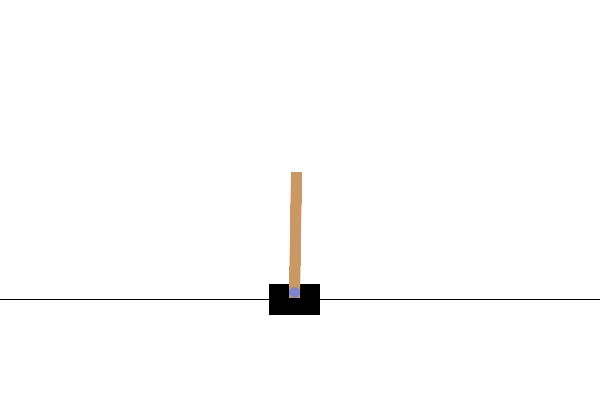


In [ ]:
import gym
import numpy as np
from tqdm import tqdm

In [ ]:
env = gym.make('CartPole-v1')

**Action Space**

The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

*   0: Push cart to the left
*   1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

In [ ]:
print("Action Space {}".format(env.action_space))

**Observation Space**

The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

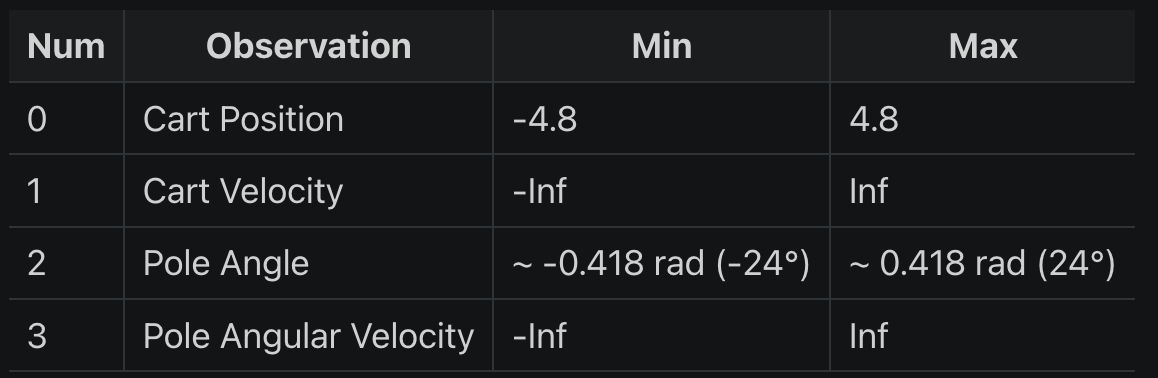

In [ ]:
print("Observation Space {}".format(env.observation_space))

**Reward**

Since the goal is to keep the pole upright for as long as possible, by default, a reward of +1 is given for every step taken, including the termination step. The default reward threshold is 500 for v1 and 200 for v0 due to the time limit on the environment.

If sutton_barto_reward=True, then a reward of 0 is awarded for every non-terminating step and -1 for the terminating step. As a result, the reward threshold is 0 for v0 and v1.

**Starting State**

All observations are assigned a uniformly random value in (-0.05, 0.05)

**Episode End**

The episode ends if any one of the following occurs:

*   Termination: Pole Angle is greater than ±12°
*   Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
*   Truncation: Episode length is greater than 500 (200 for v0)

# Sources

In [ ]:
from typing import Optional, List
from pdb import set_trace as stop

import torch.nn as nn


def get_model(
    input_dim: int,
    output_dim: int,
    hidden_layers: Optional[List[int]] = None,
):
    """
    Feed-forward network, made of linear layers with ReLU activation functions
    The number of layers, and their size is given by `hidden_layers`.
    """
    # assert init_method in {'default', 'xavier'}

    if hidden_layers is None:
        # linear model
        model = nn.Sequential(nn.Linear(input_dim, output_dim))

    else:
        # neural network
        # there are hidden layers in this case.
        dims = [input_dim] + hidden_layers + [output_dim]
        modules = []
        for i, dim in enumerate(dims[:-2]):
            modules.append(nn.Linear(dims[i], dims[i + 1]))
            modules.append(nn.ReLU())

        modules.append(nn.Linear(dims[-2], dims[-1]))
        model = nn.Sequential(*modules)
        # stop()

    # n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # print(f'{n_parameters:,} parameters')

    return model

def count_parameters(model: nn.Module) -> int:
    """"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))


class AgentMemory:

    def __init__(self, memory_size):
        self.memory = deque([], maxlen=memory_size)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)

        # stop()

        return Transition(*zip(*transitions))

    def __len__(self):
        return len(self.memory)

In [ ]:
import os
from typing import Callable, Dict, Tuple, List
import pathlib
from pathlib import Path
import json

import numpy as np
import gym
import yaml
import torch.nn as nn


def snake_to_camel(word):
    import re
    return ''.join(x.capitalize() or '_' for x in word.split('_'))


def get_agent_id(env_name: str) -> str:

    dir = Path(SAVED_AGENTS_DIR) / env_name
    if not dir.exists():
        os.makedirs(dir)

    ids = []
    for id in os.listdir(dir):
        try:
            ids.append(int(id))
        except:
            pass
    if len(ids) > 0:
        agent_id = max(ids) + 1
    else:
        agent_id = 0


    return str(agent_id)

def get_input_output_dims(env_name: str) -> Tuple[int]:
    """"""
    if 'MountainCar' in env_name:
        input_dim = 2
        output_dim = 3
    elif 'CartPole' in env_name:
        input_dim = 4
        output_dim = 2
    else:
        raise Exception('Invalid environment')

    return input_dim, output_dim


def get_epsilon_decay_fn(
    eps_start: float,
    eps_end: float,
    total_episodes: int
) -> Callable:
    """
    Returns function epsilon_fn, which depends on
    a single input, step, which is the current episode
    """
    def epsilon_fn(episode: int) -> float:
        r = max((total_episodes - episode) / total_episodes, 0)
        return (eps_start - eps_end)*r + eps_end

    return epsilon_fn


def get_epsilon_exponential_decay_fn(
    eps_max: float,
    eps_min: float,
    decay: float,
) -> Callable:
    """
    Returns function epsilon_fn, which depends on
    a single input, step, which is the current episode
    """
    def epsilon_fn(episode: int) -> float:
        return max(eps_min, eps_max * (decay ** episode))
    return epsilon_fn


def get_success_rate_from_n_steps(env: gym.Env, steps: List[int]):

    import numpy as np
    if 'MountainCar' in str(env):
        success_rate = np.mean((np.array(steps) < env._max_episode_steps) * 1.0)
    elif 'CartPole' in str(env):
        success_rate = np.mean((np.array(steps) >= env._max_episode_steps) * 1.0)
    else:
        raise Exception('Invalid environment name')

    return success_rate

def get_observation_samples(env: gym.Env, n_samples: int) -> np.array:
    """"""
    samples = []
    state = env.reset()
    while len(samples) < n_samples:

        samples.append(np.copy(state))
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)

        if done:
            state = env.reset()
        else:
            state = next_state

    return np.array(samples)


def set_seed(
    env,
    seed
):
    """To ensure reproducible runs we fix the seed for different libraries"""
    import random
    random.seed(seed)

    import numpy as np
    np.random.seed(seed)

    env.reset(seed=seed)
    env.action_space.seed(seed)

    import torch
    torch.manual_seed(seed)

    # Deterministic operations for CuDNN, it may impact performances
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_num_model_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from typing import Tuple, List, Callable, Union, Optional
import random
from pathlib import Path
from collections import deque
from pdb import set_trace as stop

import numpy as np
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter



def train(
    agent,
    env,
    n_episodes: int,
    log_dir: Optional[Path] = None,
    max_steps: Optional[int] = float("inf"),
    n_episodes_evaluate_agent: Optional[int] = 100,
    freq_episodes_evaluate_agent: int = 200,
) -> None:

    # Tensorborad log writer
    logging = False
    if log_dir is not None:
        writer = SummaryWriter(log_dir)
        logging = True

    reward_per_episode = []
    steps_per_episode = []
    global_step_counter = 0

    for i in tqdm(range(0, n_episodes)):

        state = env.reset()

        rewards = 0
        steps = 0
        done = False
        while not done:

            action = agent.act(state)

            # agents takes a step and the environment throws out a new state and
            # a reward
            next_state, reward, done, info = env.step(action)

            # agent observes transition and stores it for later use
            agent.observe(state, action, reward, next_state, done)

            # learning happens here, through experience replay
            agent.replay()

            global_step_counter += 1
            steps += 1
            rewards += reward
            state = next_state

        # log to Tensorboard
        if logging:
            writer.add_scalar('train/rewards', rewards, i)
            writer.add_scalar('train/steps', steps, i)
            writer.add_scalar('train/epsilon', agent.epsilon, i)
            writer.add_scalar('train/replay_memory_size', len(agent.memory), i)

        reward_per_episode.append(rewards)
        steps_per_episode.append(steps)

        # if (i > 0) and (i % freq_episodes_evaluate_agent) == 0:
        if (i + 1) % freq_episodes_evaluate_agent == 0:
            # evaluate agent
            eval_rewards, eval_steps = evaluate(agent, env,
                                                n_episodes=n_episodes_evaluate_agent,
                                                epsilon=0.01)

            # from src.utils import get_success_rate_from_n_steps
            # success_rate = get_success_rate_from_n_steps(env, eval_steps)
            print(f'Reward mean: {np.mean(eval_rewards):.2f}, std: {np.std(eval_rewards):.2f}')
            print(f'Num steps mean: {np.mean(eval_steps):.2f}, std: {np.std(eval_steps):.2f}')
            # print(f'Success rate: {success_rate:.2%}')
            if logging:
                writer.add_scalar('eval/avg_reward', np.mean(eval_rewards), i)
                writer.add_scalar('eval/avg_steps', np.mean(eval_steps), i)
            # writer.add_scalar('eval/success_rate', success_rate, i)

        if global_step_counter > max_steps:
            break


def evaluate(
    agent,
    env,
    n_episodes: int,
    epsilon: Optional[float] = None,
    seed: Optional[int] = 0,
) -> Tuple[List, List]:

    set_seed(env, seed)

    # output metrics
    reward_per_episode = []
    steps_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        state = env.reset()
        rewards = 0
        steps = 0
        done = False
        while not done:

            action = agent.act(state, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)

            rewards += reward
            steps += 1
            state = next_state

        reward_per_episode.append(rewards)
        steps_per_episode.append(steps)

    return reward_per_episode, steps_per_episode

In [ ]:
SAVED_AGENTS_DIR = 'saved_agents'
TENSORBOARD_LOG_DIR = 'tensorboard_logs'
OPTUNA_DB = 'optuna.db'
DATA_SUPERVISED_ML = 'data_supervised_ml'
MLFLOW_RUNS_DIR = 'mlflow_runs'

!mkdir SAVED_AGENTS_DIR
!mkdir TENSORBOARD_LOG_DIR
!mkdir DATA_SUPERVISED_ML
!mkdir MLFLOW_RUNS_DIR

In [ ]:
import os
from pathlib import Path
from typing import Union, Callable, Tuple, List
import random
from argparse import ArgumentParser

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F


class QAgent:

    def __init__(
        self,
        env: gym.Env,
        learning_rate: float = 1e-4,
        discount_factor: float = 0.99,
        batch_size: int = 64,
        memory_size: int = 10000,
        freq_steps_update_target: int = 1000,
        n_steps_warm_up_memory: int = 1000,
        freq_steps_train: int = 16,
        n_gradient_steps: int = 8,
        nn_hidden_layers: List[int] = None,
        max_grad_norm: int = 10,
        normalize_state: bool = False,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.05,
        steps_epsilon_decay: float = 50000,
        log_dir: str = None,
    ):

        self.env = env

        # general hyper-parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # replay memory we use to sample experiences and update parameters
        # `memory_size` defines the maximum number of past experiences we want the
        # agent remember.
        self.memory_size = memory_size
        self.memory = AgentMemory(memory_size)

        # number of experiences we take at once from `self.memory` to update parameters
        self.batch_size = batch_size

        # hyper-parameters to control exploration of the environment
        self.steps_epsilon_decay = steps_epsilon_decay
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_fn = get_epsilon_decay_fn(epsilon_start, epsilon_end, steps_epsilon_decay)
        self.epsilon = None

        # create q model(s). Plural because we use 2 models: main one, and the other for the target.
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_net, self.target_q_net = None, None
        self._init_models(nn_hidden_layers)
        print(f'{get_num_model_parameters(self.q_net):,} parameters')
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=learning_rate) # Adam optimizer is a safe and standard choice
        self.max_grad_norm = max_grad_norm

        # hyper-parameters to control how often or when we do certain things, like
        # - update the main net parameters
        self.freq_steps_train = freq_steps_train
        # - update the target net parameters
        self.freq_steps_update_target = freq_steps_update_target
        # - start training until the memory is big enough
        assert n_steps_warm_up_memory > batch_size, 'batch_size must be larger than n_steps_warm_up_memory'
        self.n_steps_warm_up_memory = n_steps_warm_up_memory
        # - number of gradient steps we perform every time we update the main net parameters
        self.n_gradient_steps = n_gradient_steps

        # state variable we use to keep track of the number of calls to `observe()`
        self._step_counter = 0

        # input normalizer
        self.normalize_state = normalize_state
        if normalize_state:
            state_samples = get_observation_samples(env, n_samples=10000)
            self.mean_states = state_samples.mean(axis=0)
            self.std_states = state_samples.std(axis=0)

        # create a tensorboard logger if `log_dir` was provided
        # logging becomes crucial to understand what is not working in our code.
        self.log_dir = log_dir
        if log_dir:
            self.logger = SummaryWriter(log_dir)

        # save hyper-parameters
        self.hparams = {
            'learning_rate': learning_rate,
            'discount_factor': discount_factor,
            'batch_size': batch_size,
            'memory_size': memory_size,
            'freq_steps_update_target': freq_steps_update_target,
            'n_steps_warm_up_memory': n_steps_warm_up_memory,
            'freq_steps_train': freq_steps_train,
            'n_gradient_steps': n_gradient_steps,
            'nn_hidden_layers': nn_hidden_layers,
            'max_grad_norm': max_grad_norm,
            'normalize_state': normalize_state,
            'epsilon_start': epsilon_start,
            'epsilon_end': epsilon_end,
            'steps_epsilon_decay': steps_epsilon_decay,
        }

    def _init_models(self, nn_hidden_layers):

        # state is a vector of dimension 4, and 2 are the possible actions
        input_dim, output_dim = get_input_output_dims(str(self.env))
        self.q_net = get_model(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_layers=nn_hidden_layers,
        )
        self.q_net.to(self.device)

        # target q-net
        self.target_q_net = get_model(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_layers=nn_hidden_layers,
        )
        self.target_q_net.to(self.device)

        # copy parameters from the `self.q_net`
        self._copy_params_to_target_q_net()

    def _copy_params_to_target_q_net(self):
        """
        Copies parameters from q_net to target_q_net
        """
        for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(param.data)

    def _normalize_state(self, state: np.array) -> np.array:
        """"""
        # return (state - self.min_states) / (self.max_states - self.min_states)
        return (state - self.mean_states) / (self.std_states)

    def _preprocess_state(self, state: np.array) -> np.array:

        # state = np.copy(state_)

        if len(state.shape) == 1:
            # add extra dimension to make sure it is 2D
            s = state.reshape(1, -1)
        else:
            s = state

        if self.normalize_state:
            s = self._normalize_state(s)

        return s

    def act(self, state: np.array, epsilon: float = None) -> int:
        """
        Behavioural policy
        """
        if epsilon is None:
            # update epsilon
            self.epsilon = self.epsilon_fn(self._step_counter)
            epsilon = self.epsilon

        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = self.env.action_space.sample()
            return action

        # make sure s is a numpy array with 2 dimensions,
        # and normalize it if `self.normalize_state = True`
        s = self._preprocess_state(state)

        # forward pass through the net to compute q-values for the 3 actions
        s = torch.from_numpy(s).float().to(self.device)
        q_values = self.q_net(s)

        # extract index max q-value and reshape tensor to dimensions (1, 1)
        action = q_values.max(1)[1].view(1, 1)

        # tensor to float
        action = action.item()

        return action

    def observe(self, state, action, reward, next_state, done) -> None:

        # preprocess state
        s = self._preprocess_state(state)
        ns = self._preprocess_state(next_state)

        # store new experience in the agent's memory.
        self.memory.push(s, action, reward, ns, done)

        self._step_counter += 1

    def replay(self) -> None:

        if self._step_counter % self.freq_steps_train != 0:
            # update parameters every `self.freq_steps_update_target`
            # this way we add inertia to the agent actions, as they are more sticky
            return

        if self._step_counter < self.n_steps_warm_up_memory:
            # memory needs to be larger, no training yet
            return

        if self._step_counter % self.freq_steps_update_target == 0:
            # we update the target network parameters
            # self.target_nn.load_state_dict(self.nn.state_dict())
            self._copy_params_to_target_q_net()

        losses = []
        for i in range(0, self.n_gradient_steps):

            # get batch of experiences from the agent's memory.
            batch = self.memory.sample(self.batch_size)

            # A bit of plumbing to transform numpy arrays to PyTorch tensors
            state_batch = torch.cat([torch.from_numpy(s).float().view(1, -1) for s in batch.state]).to(self.device)
            action_batch = torch.cat([torch.tensor([[a]]).long().view(1, -1) for a in batch.action]).to(self.device)
            reward_batch = torch.cat([torch.tensor([r]).float() for r in batch.reward]).to(self.device)
            next_state_batch = torch.cat([torch.from_numpy(s).float().view(1, -1) for s in batch.next_state]).to(self.device)
            done_batch = torch.tensor(batch.done).float().to(self.device)

            # q_values for all 3 actions
            q_values = self.q_net(state_batch)

            # keep only q_value for the chosen action in the trajectory, i.e. `action_batch`
            q_values = q_values.gather(1, action_batch)

            with torch.no_grad():
                # q-values for each action in next_state
                next_q_values = self.target_q_net(next_state_batch)

                # extract max q-value for each next_state
                next_q_values, _ = next_q_values.max(dim=1)

                # TD target
                target_q_values = (1 - done_batch) * next_q_values * self.discount_factor + reward_batch

            # compute loss
            loss = F.mse_loss(q_values.squeeze(1), target_q_values)
            losses.append(loss.item())

            # backward step to adjust network parameters
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), self.max_grad_norm)
            self.optimizer.step()



def parse_arguments():
    """
    Hyper-parameters are set either from command line or from the `hyperparameters.yaml' file.
    Parameters set throught the command line have priority over the default ones
    set in the yaml file.
    """

    parser = ArgumentParser()
    parser.add_argument('--env', type=str, required=True)
    parser.add_argument('--learning_rate', type=float)
    parser.add_argument('--discount_factor', type=float)
    parser.add_argument('--episodes', type=int)
    parser.add_argument('--max_steps', type=int)
    parser.add_argument('--epsilon_start', type=float)
    parser.add_argument('--epsilon_end', type=float)
    parser.add_argument('--steps_epsilon_decay', type=int)
    parser.add_argument('--batch_size', type=int)
    parser.add_argument('--memory_size', type=int)
    parser.add_argument('--n_steps_warm_up_memory', type=int)
    parser.add_argument('--freq_steps_update_target', type=int)
    parser.add_argument('--freq_steps_train', type=int)
    parser.add_argument('--normalize_state', dest='normalize_state', action='store_true')
    parser.set_defaults(normalize_state=False)
    parser.add_argument('--n_gradient_steps', type=int,)
    parser.add_argument("--nn_hidden_layers", type=int, nargs="+",)
    parser.add_argument('--nn_init_method', type=str, default='default')
    parser.add_argument('--loss', type=str)
    parser.add_argument("--max_grad_norm", type=float, default=10)
    parser.add_argument('--n_episodes_evaluate_agent', type=int, default=100)
    parser.add_argument('--freq_episodes_evaluate_agent', type=int, default=100)
    parser.add_argument('--seed', type=int, default=0)

    args = parser.parse_args()

    args_dict = {}
    for arg in vars(args):
        args_dict[arg] = getattr(args, arg)

    print('Hyper-parameters')
    for key, value in args_dict.items():
        print(f'{key}: {value}')

    return args_dict


# Linear Q-agent

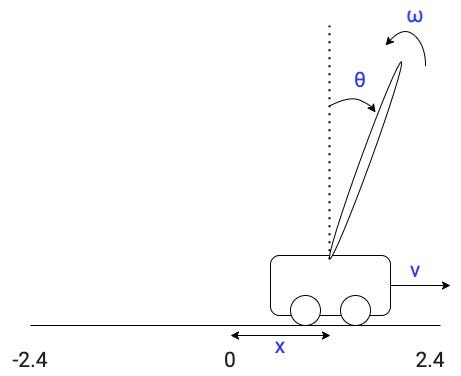

*   x is the cart position
*   v is the cart velocity
*   θ is the pole angle
*   ω is the pole angular velocity

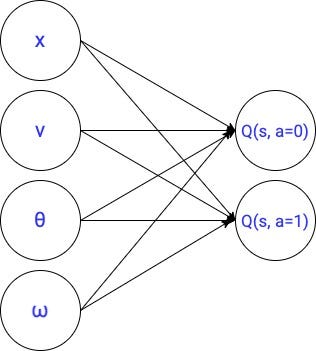

In [ ]:
hparams = {
    'learning_rate': 9.214691713730938e-05,
    'discount_factor': 0.99,
    'batch_size': 32,
    'memory_size': 10000,
    'freq_steps_train': 16,
    'freq_steps_update_target': 1000,
    'n_steps_warm_up_memory': 1000,
    'n_gradient_steps': 1,
    'max_grad_norm': 1,
    'normalize_state': True,
    'epsilon_start': 0.9,
    'epsilon_end': 0.08474621504763855,
    'steps_epsilon_decay': 100000
}

SEED = 4291201652
set_seed(env, SEED)
agent = QAgent(env, **hparams)

In [ ]:
hparams = {
    'learning_rate': 0.0005652080372498697,
    'discount_factor': 0.99,
    'batch_size': 64,
    'memory_size': 100000,
    'freq_steps_train': 128,
    'freq_steps_update_target': 100,
    'n_steps_warm_up_memory': 1000,
    'n_gradient_steps': 4,
    'max_grad_norm': 10,
    'normalize_state': False,
    'epsilon_start': 0.9,
    'epsilon_end': 0.0429612235926375,
    'steps_epsilon_decay': 1000
}

SEED = 2636569667
set_seed(env, SEED)
agent = QAgent(env, **hparams)

In [ ]:
train(agent, env, n_episodes=2000)

# Evaluation

In [ ]:
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

In [ ]:
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

# Deep Q-agent

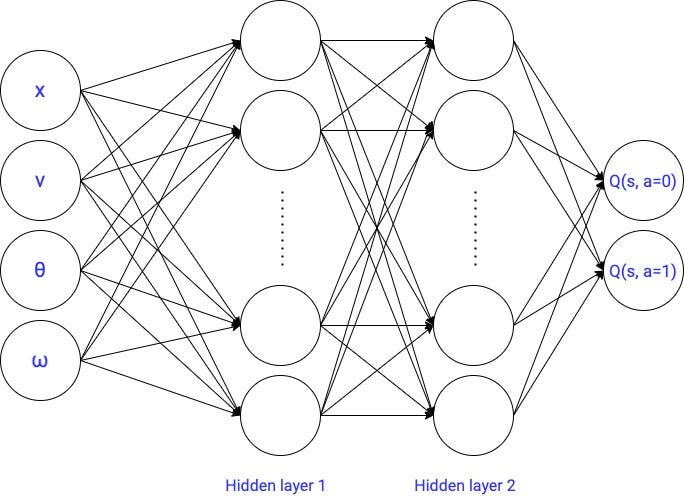

In [ ]:
hparams = {
    "learning_rate": 0.00045095481485457226,
    "discount_factor": 0.99,
    "batch_size": 16,
    "memory_size": 100000,
    "freq_steps_update_target": 10,
    "n_steps_warm_up_memory": 1000,
    "freq_steps_train": 8,
    "n_gradient_steps": 16,
    "nn_hidden_layers": [256, 256],
    "max_grad_norm": 1,
    "normalize_state": False,
    "epsilon_start": 0.9,
    "epsilon_end": 0.06286625175600052,
    "steps_epsilon_decay": 10000
}

SEED = 2386916045
set_seed(env, SEED)
agent = QAgent(env, **hparams)

In [ ]:
train(agent, env, n_episodes=200)

# Evaluation

In [ ]:
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()